![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FDev%2Fnew&file=Model+Monitoring+-+HOLDING+BIN.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Dev/new/Model%20Monitoring%20-%20HOLDING%20BIN.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FDev%2Fnew%2FModel%2520Monitoring%2520-%2520HOLDING%2520BIN.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Dev/new/Model%20Monitoring%20-%20HOLDING%20BIN.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Dev/new/Model%20Monitoring%20-%20HOLDING%20BIN.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Holding Bin

---
## Feature Engineering

To prepare for machine learning, the next step is transforming the columns into features - feature engineering.

BigQuery provides many helpful functions for feature engineering as covered by this previous blog post: [How to use advanced feature engineering to preprocess data in BigQuery ML](https://cloud.google.com/blog/products/data-analytics/feature-engineering-inside-the-model-with-bigquery-and-vertex-ai).  The feature engineering steps will need to be repeated for future stages like evaluation, testing, and monitoring.  BigQuery ML models can do this automatically with inline transformations for models using the [`TRANSFORM` clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).

> **NOTE:** The accompanying [introduction notebook](link here) uses the inline transformation during model training. 

For this tutorial we will take advantage of modualar feature engineering with a [`TRANSFORM_ONLY` model](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-transform) as featured in this previous blog post: [Making BigQuery ML feature preprocessing reusable and modular](https://cloud.google.com/blog/products/data-analytics/how-bigquery-ml-does-feature-preprocessing).  The `TRANSFORM_ONLY` model can be reused anywhere - training multiple models, for prediction, evaluation, monitoring, and more!

### Create a `TRANSFORM_ONLY` Model

[BigQuery ML](https://cloud.google.com/bigquery/docs/bqml-introduction) includes built ability to train model using a wide variety of model types by using the [`CREATE MODEL`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create) statement.  For a full overview of the available model choice check out the [end-to-end user journey for each model](https://cloud.google.com/bigquery/docs/e2e-journey).

When using the `CREATE MODEL` statement feature engineering can be directly applied within the model with by using the [`TRANSFORM`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform) clause to apply [preprocessing functions](https://cloud.google.com/bigquery/docs/manual-preprocessing).  Models trained this way will also apply the transformation during serving time.  You can even reuse just the transformations with the [`ML.TRANSFORM`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-transform) function.

For this workflow we [created a transform-only model](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-transform) specially for just feature engineering. The syntax is very similar to the other BigQuery ML model types.  It still uses the [`CREATE MODEL`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create) statement with the [`TRANSFORM`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform) clause to apply [preprocessing functions](https://cloud.google.com/bigquery/docs/manual-preprocessing) but the only model option needed is `MODEL_TYPE = 'TRANSFORM_ONLY'`.  

All of the options in the `TRANSFORM` statement will become part of the model and will remember any calculated parameters (like `mean` and `sd` for standardization).  This makes the transformation reusable with the [`ML.TRANSFORM`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-transform) function.

From reviewing the training data above, the following transformations are desired:
- Apply [`ML.ROBUST_SCALER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-robust-scaler) to `body_mass_g`
- Apply [`ML.STANDARD_SCALER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-standard-scaler) to `culmen_depth_mm` and `culmen_length_mm`
- Apply [`ML.QUANTILE_BUCKATIZE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-quantile-bucketize) to `flipper_length_mm`
- Apply [`ML.IMPUTER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-imputer) to `island`, and `sex`

In [13]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml_model_monitoring.feature_engineering`
    TRANSFORM(
        ML.ROBUST_SCALER(body_mass_g) OVER() AS body_mass_g,
        ML.STANDARD_SCALER(culmen_length_mm) OVER() AS culmen_length_mm,
        ML.STANDARD_SCALER(culmen_depth_mm) OVER() AS culmen_depth_mm,
        ML.QUANTILE_BUCKETIZE(flipper_length_mm, 3) OVER() AS flipper_length_mm,
        ML.IMPUTER(sex, 'most_frequent') OVER() AS sex,
        ML.IMPUTER(island, 'most_frequent') OVER() AS island
    )
    OPTIONS(
        model_type = 'TRANSFORM_ONLY'
    )
AS
    SELECT * EXCEPT(splits, species)
    FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
    WHERE splits = 'TRAIN'

Query is running:   0%|          |

""


### Review the Training Split - Transformed

Now, use the `ML.DESCRIBE_DATA` function on the transformed data using the [`ML.TRANSFORM`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-transform) function. Notice the scale of the transformed numeric columns is changed (`body_mass_g` for example), as the nulls are filled in for the string column `sex`.

In [14]:
%%bigquery
SELECT *
FROM ML.DESCRIBE_DATA(
    (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.feature_engineering`,
            (
                SELECT * EXCEPT(splits, species)
                FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
                WHERE splits = 'TRAIN'
            )
        )
    ),
    STRUCT(3 AS top_k, 4 AS num_quantiles)
)

Query is running:   0%|          |

Downloading:   0%|          |

,name,num_rows,num_nulls,num_zeros,min,max,mean,stddev,median,quantiles,unique,avg_string_length,num_values,top_values,min_array_length,max_array_length,avg_array_length,total_array_length,array_length_quantiles,dimension
0,body_mass_g,238,1,4,-1.0833333333333333,1.9166666666666667,0.154360,0.652118,0.000000,"[-1.0833333333333333, -0.375, 0.0, 0.625, 1.91...",<NA>,NaN,237,[],<NA>,<NA>,NaN,<NA>,[],<NA>
1,culmen_depth_mm,238,1,0,-1.9942971985880726,2.2394462467609313,0.000002,1.000000,0.097070,"[-1.9942971985880726, -0.8210911836118423, 0.0...",<NA>,NaN,237,[],<NA>,<NA>,NaN,<NA>,[],<NA>
2,culmen_length_mm,238,1,0,-2.1040180527800154,2.2237031837845005,-0.000003,1.000000,0.078026,"[-2.1040180527800154, -0.86752627090444, 0.078...",<NA>,NaN,237,[],<NA>,<NA>,NaN,<NA>,[],<NA>
3,flipper_length_mm,238,1,<NA>,bin_1,bin_3,NaN,NaN,NaN,[],3,5.000000,237,"[{'value': 'bin_2', 'count': 85}, {'value': 'b...",<NA>,<NA>,NaN,<NA>,[],<NA>
4,island,238,0,<NA>,Biscoe,Torgersen,NaN,NaN,NaN,[],3,6.092437,238,"[{'value': 'Biscoe', 'count': 116}, {'value': ...",<NA>,<NA>,NaN,<NA>,[],<NA>
5,sex,238,0,<NA>,FEMALE,MALE,NaN,NaN,NaN,[],2,5.050420,238,"[{'value': 'FEMALE', 'count': 125}, {'value': ...",<NA>,<NA>,NaN,<NA>,[],<NA>


### Introduce Changes Over Time

To illustrate the impact of change over time, the following code creates a new set of data from the test split.  It creates a series of changes to measurements for each of the past 30 days.  In each case, the values of the parameters `flipper_length_mm` and `body_mass_g` are allowed to slightly increase which can accumulate over the timespan. This might mimic a potential growth season for the penguins that might not have been represented in the training data.  


One possible data architeuctre for feature management is collecting feature changes in a sparse table - a history table.  In this form the changes are accompanied by a timestamp.  To collapse feature data for a subject into a single record at a point-inn-time there are several BigQuery functions to simplify this action.  With this in mind, for this example only changes are written to the table and each row inserted is marked with the timestamp in the column `feature_timestamp`.  The penguin the measurement is for is noted in the new column `entity_id`. 

In [33]:
%%bigquery
DECLARE counter INT64 DEFAULT 30;

# actual data as starting point - add entity_id, and feature_timestamp:
CREATE OR REPLACE TABLE `statmike-mlops-349915.bqml_model_monitoring.production` AS
    SELECT * EXCEPT(splits),
        CAST(ROW_NUMBER() OVER() AS STRING) AS entity_id,
        TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL counter+1 DAY) AS feature_timestamp
    FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
    WHERE splits = 'TEST';

LOOP
    SET counter = counter - 1;
    IF counter < 0 THEN LEAVE;
    END IF;
    INSERT `statmike-mlops-349915.bqml_model_monitoring.production` (entity_id, feature_timestamp, flipper_length_mm)
        SELECT entity_id,
            TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL counter+1 DAY) AS feature_timestamp,
            flipper_length_mm + 4*(RAND()-0.1) AS flipper_length_mm
        FROM ML.FEATURES_AT_TIME(
            TABLE `statmike-mlops-349915.bqml_model_monitoring.production`,
            time => CURRENT_TIMESTAMP(),
            num_rows => 1,
            ignore_feature_nulls => TRUE
        )
        WHERE RAND() < 0.4;
    INSERT `statmike-mlops-349915.bqml_model_monitoring.production` (entity_id, feature_timestamp, body_mass_g)
        SELECT entity_id,
            TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL counter+1 DAY) AS feature_timestamp,
            body_mass_g + 80*(RAND()-0.1) AS body_mass_g
        FROM ML.FEATURES_AT_TIME(
            TABLE `statmike-mlops-349915.bqml_model_monitoring.production`,
            time => CURRENT_TIMESTAMP(),
            num_rows => 1,
            ignore_feature_nulls => TRUE
        )
        WHERE RAND() < 0.70;
END LOOP;

Query is running:   0%|          |

""


### Review The Raw Feature History: For a Single Penguin

Reviewing the history for one penugin, `entity_id = '1'` shows a history of changes to the features `flipper_length_mm` and `body_mass_g`. The other features are unchanged and noted as null values.  This is a time table or history table for the features.  In the sections that follow, this table will be used to extract feature values at points-in-time.

In [43]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.bqml_model_monitoring.production`
WHERE entity_id = '1'
ORDER BY feature_timestamp

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,entity_id,feature_timestamp
0,Adelie Penguin (Pygoscelis adeliae),Torgersen,NaN,NaN,NaN,NaN,None,1,2024-03-04 14:14:24.656924+00:00
1,None,None,NaN,NaN,NaN,NaN,None,1,2024-03-05 14:14:27.803600+00:00
2,None,None,NaN,NaN,NaN,NaN,None,1,2024-03-05 14:14:30.533996+00:00
3,None,None,NaN,NaN,NaN,NaN,None,1,2024-03-06 14:14:37.165137+00:00
4,None,None,NaN,NaN,NaN,NaN,None,1,2024-03-08 14:14:47.577282+00:00
5,None,None,NaN,NaN,NaN,NaN,None,1,2024-03-09 14:14:57.622038+00:00
6,None,None,NaN,NaN,NaN,NaN,None,1,2024-03-10 14:15:04.178237+00:00
7,None,None,NaN,NaN,NaN,NaN,None,1,2024-03-11 14:15:07.560597+00:00
8,None,None,NaN,NaN,NaN,NaN,None,1,2024-03-11 14:15:10.758457+00:00
9,None,None,NaN,NaN,NaN,NaN,None,1,2024-03-12 14:15:18.313534+00:00


### Review The Raw Feature Values At A Point-In-Time

There are BigQuery functions available to make it easy to create training, evaluation, and other sets of instances from a history table.

- [`ML.FEATURES_AT_TIME`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-feature-time) specify a point-in-time cutoff for all entities when retrieving features. Prevents data leakage).
- [`ML.ENTITY_FEATURES_AT_TIME`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-entity-feature-time) specify a table of entity values and timestamps to retrieve point-in-time features for all combinations

Use the `ML.FEATURE_AT_TIME` function to review the latest raw feature values for the first 10 pinguns:

In [37]:
%%bigquery
SELECT *
FROM ML.FEATURES_AT_TIME(
    (SELECT * FROM `statmike-mlops-349915.bqml_model_monitoring.production` WHERE entity_id in ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10')),
    time => CURRENT_TIMESTAMP(),
    num_rows => 1,
    ignore_feature_nulls => TRUE
)

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,entity_id,feature_timestamp
0,Adelie Penguin (Pygoscelis adeliae),Dream,40.8,18.9,226.687378,4823.540926,MALE,9,2024-04-04 14:19:18.019664+00:00
1,Adelie Penguin (Pygoscelis adeliae),Dream,39.0,18.7,206.626655,4360.351539,MALE,10,2024-04-04 14:19:18.019664+00:00
2,Adelie Penguin (Pygoscelis adeliae),Biscoe,42.0,19.5,215.080442,4701.525350,MALE,7,2024-04-04 14:19:18.019664+00:00
3,Adelie Penguin (Pygoscelis adeliae),Dream,43.2,18.5,205.583201,4760.666425,MALE,6,2024-04-04 14:19:18.019664+00:00
4,Adelie Penguin (Pygoscelis adeliae),Torgersen,NaN,NaN,NaN,NaN,None,1,2024-04-04 14:19:18.019664+00:00
5,Gentoo penguin (Pygoscelis papua),Biscoe,48.7,15.7,218.231090,5949.516995,MALE,8,2024-04-04 14:19:18.019664+00:00
6,Adelie Penguin (Pygoscelis adeliae),Torgersen,37.8,17.3,201.436430,4437.826663,None,4,2024-04-04 14:19:18.019664+00:00
7,Gentoo penguin (Pygoscelis papua),Biscoe,44.5,14.3,234.668929,4857.940574,None,2,2024-04-04 14:19:18.019664+00:00
8,Adelie Penguin (Pygoscelis adeliae),Biscoe,39.7,18.9,200.809007,4444.151953,MALE,5,2024-04-04 14:19:18.019664+00:00
9,Gentoo penguin (Pygoscelis papua),Biscoe,44.5,15.7,239.786667,5517.615850,None,3,2024-04-04 14:19:18.019664+00:00


### Review The Raw Features Pattern Over Time

Plot the raw features for 10 penguins to see the changes over the last 30 days using [`ML.ENTITY_FEATURES_AT_TIME`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-entity-feature-time) to extract point-in-time feature values for the set:

In [44]:
%%bigquery penguins
WITH
    TIME_TABLE AS (
        SELECT TIMESTAMP(feature_date) AS time
        FROM UNNEST(GENERATE_DATE_ARRAY(DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY), CURRENT_DATE())) AS feature_date
    ),
    ENTITY_TABLE AS (
        SELECT CAST(id AS STRING) AS entity_id
        FROM UNNEST(GENERATE_ARRAY(1, 10)) AS id
    ),
    ENTITY_TIME_TABLE AS (
        SELECT *
        FROM ENTITY_TABLE
        CROSS JOIN TIME_TABLE
    )
SELECT *
FROM ML.ENTITY_FEATURES_AT_TIME(
    TABLE `statmike-mlops-349915.bqml_model_monitoring.production`,
    TABLE ENTITY_TIME_TABLE,
    num_rows => 1,
    ignore_feature_nulls => TRUE
)
ORDER BY entity_id, feature_timestamp

Query is running:   0%|          |

Downloading:   0%|          |

In [45]:
penguins.set_index('feature_timestamp', inplace = True)

entity_id
1     Axes(0.125,0.11;0.775x0.77)
10    Axes(0.125,0.11;0.775x0.77)
2     Axes(0.125,0.11;0.775x0.77)
3     Axes(0.125,0.11;0.775x0.77)
4     Axes(0.125,0.11;0.775x0.77)
5     Axes(0.125,0.11;0.775x0.77)
6     Axes(0.125,0.11;0.775x0.77)
7     Axes(0.125,0.11;0.775x0.77)
8     Axes(0.125,0.11;0.775x0.77)
9     Axes(0.125,0.11;0.775x0.77)
Name: flipper_length_mm, dtype: object

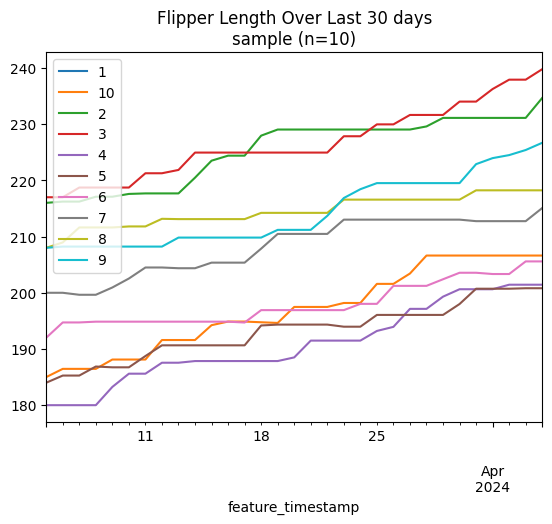

In [46]:
penguins.groupby('entity_id')['flipper_length_mm'].plot(legend = True, title = 'Flipper Length Over Last 30 days\nsample (n=10)')

entity_id
1     Axes(0.125,0.11;0.775x0.77)
10    Axes(0.125,0.11;0.775x0.77)
2     Axes(0.125,0.11;0.775x0.77)
3     Axes(0.125,0.11;0.775x0.77)
4     Axes(0.125,0.11;0.775x0.77)
5     Axes(0.125,0.11;0.775x0.77)
6     Axes(0.125,0.11;0.775x0.77)
7     Axes(0.125,0.11;0.775x0.77)
8     Axes(0.125,0.11;0.775x0.77)
9     Axes(0.125,0.11;0.775x0.77)
Name: body_mass_g, dtype: object

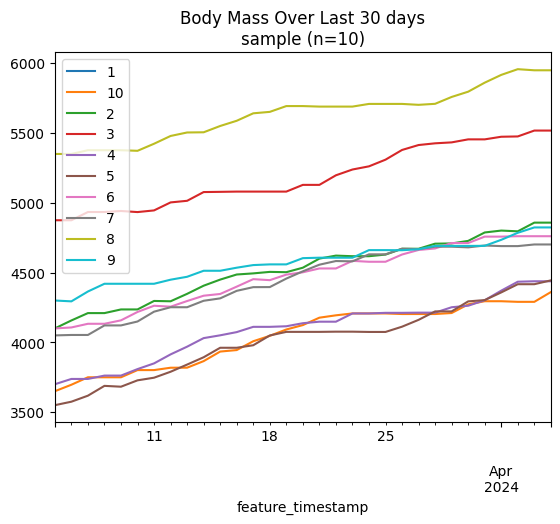

In [47]:
penguins.groupby('entity_id')['body_mass_g'].plot(legend = True, title = 'Body Mass Over Last 30 days\nsample (n=10)')

### Create A Transformed Feature View

The tasks below include creating evaluations and monitoring features.  This means applying the feature engineering to the data with the `TRANSFORM_ONLY` model created above.  To make using the data easier, a view is created that applys the feature engineering model to the data.

>**NOTE:**  By applying `TRANSFORM_ONLY` models to feature raw value tables the data can be made easier to use for prediction and other tasks that require the transformed feature.  Also, by using views like this the the same feature sources can be used across different views for different models with different feature engineering.  A single source can be used over and over for training and serving models with replicating it and maintaining versions.

In [48]:
%%bigquery
CREATE OR REPLACE VIEW `statmike-mlops-349915.bqml_model_monitoring.production_features` AS
    SELECT *
    FROM ML.TRANSFORM(
        MODEL `statmike-mlops-349915.bqml_model_monitoring.feature_engineering`,
        (
            SELECT *
            FROM `statmike-mlops-349915.bqml_model_monitoring.production`
        )
    )

Query is running:   0%|          |

""


### Review The Transformed Feature History: For a Single Penguin

Again, review the history for one penugin, `entity_id = '1'`  but this time for the view of transformed features.  

This shows a history of changes to the features `flipper_length_mm` and `body_mass_g`. The other features are unchanged and noted as null values.  This is a time table or history table for the features.  In the sections that follow, this table will be used to extract feature values at points-in-time.

In [49]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.bqml_model_monitoring.production_features`
WHERE entity_id = '1'
ORDER BY feature_timestamp

Query is running:   0%|          |

Downloading:   0%|          |

,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,island,species,entity_id,feature_timestamp
0,NaN,NaN,NaN,None,FEMALE,Torgersen,Adelie Penguin (Pygoscelis adeliae),1,2024-03-04 14:14:24.656924+00:00
1,NaN,NaN,NaN,None,FEMALE,Biscoe,None,1,2024-03-05 14:14:27.803600+00:00
2,NaN,NaN,NaN,None,FEMALE,Biscoe,None,1,2024-03-05 14:14:30.533996+00:00
3,NaN,NaN,NaN,None,FEMALE,Biscoe,None,1,2024-03-06 14:14:37.165137+00:00
4,NaN,NaN,NaN,None,FEMALE,Biscoe,None,1,2024-03-08 14:14:47.577282+00:00
5,NaN,NaN,NaN,None,FEMALE,Biscoe,None,1,2024-03-09 14:14:57.622038+00:00
6,NaN,NaN,NaN,None,FEMALE,Biscoe,None,1,2024-03-10 14:15:04.178237+00:00
7,NaN,NaN,NaN,None,FEMALE,Biscoe,None,1,2024-03-11 14:15:07.560597+00:00
8,NaN,NaN,NaN,None,FEMALE,Biscoe,None,1,2024-03-11 14:15:10.758457+00:00
9,NaN,NaN,NaN,None,FEMALE,Biscoe,None,1,2024-03-12 14:15:18.313534+00:00


### Review Transformed Feature Values At A Point-In-Time

Use the `ML.FEATURE_AT_TIME` function to review the latest transformed feature values for the first 10 pinguns:

In [50]:
%%bigquery
SELECT *
FROM ML.FEATURES_AT_TIME(
    (SELECT * FROM `statmike-mlops-349915.bqml_model_monitoring.production_features` WHERE entity_id in ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10')),
    time => CURRENT_TIMESTAMP(),
    num_rows => 1,
    ignore_feature_nulls => TRUE
)

Query is running:   0%|          |

Downloading:   0%|          |

,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,island,species,entity_id,feature_timestamp
0,1.519614,0.876444,-0.716448,bin_3,FEMALE,Biscoe,Gentoo penguin (Pygoscelis papua),8,2024-04-04 14:38:58.907744+00:00
1,0.310261,-1.113980,0.074825,bin_2,FEMALE,Biscoe,Adelie Penguin (Pygoscelis adeliae),4,2024-04-04 14:38:58.907744+00:00
2,0.568533,-0.127898,0.668279,bin_2,FEMALE,Biscoe,Adelie Penguin (Pygoscelis adeliae),6,2024-04-04 14:38:58.907744+00:00
3,0.248281,-0.894851,0.767188,bin_2,FEMALE,Biscoe,Adelie Penguin (Pygoscelis adeliae),10,2024-04-04 14:38:58.907744+00:00
4,0.618833,-0.566157,0.866097,bin_3,FEMALE,Biscoe,Adelie Penguin (Pygoscelis adeliae),9,2024-04-04 14:38:58.907744+00:00
5,NaN,NaN,NaN,None,FEMALE,Biscoe,Adelie Penguin (Pygoscelis adeliae),1,2024-04-04 14:38:58.907744+00:00
6,1.174093,0.109492,-0.716448,bin_3,FEMALE,Biscoe,Gentoo penguin (Pygoscelis papua),3,2024-04-04 14:38:58.907744+00:00
7,0.315322,-0.767025,0.866097,bin_2,FEMALE,Biscoe,Adelie Penguin (Pygoscelis adeliae),5,2024-04-04 14:38:58.907744+00:00
8,0.521220,-0.347028,1.162824,bin_3,FEMALE,Biscoe,Adelie Penguin (Pygoscelis adeliae),7,2024-04-04 14:38:58.907744+00:00
9,0.646352,0.109492,-1.408811,bin_3,FEMALE,Biscoe,Gentoo penguin (Pygoscelis papua),2,2024-04-04 14:38:58.907744+00:00


### Review The Transformed Features Pattern Over Time

Plot the transformed features for 10 penguins to see the changes over the last 30 days using [`ML.ENTITY_FEATURES_AT_TIME`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-entity-feature-time) to extract point-in-time feature values for the set:

In [51]:
%%bigquery penguins
WITH
    TIME_TABLE AS (
        SELECT TIMESTAMP(feature_date) AS time
        FROM UNNEST(GENERATE_DATE_ARRAY(DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY), CURRENT_DATE())) AS feature_date
    ),
    ENTITY_TABLE AS (
        SELECT CAST(id AS STRING) AS entity_id
        FROM UNNEST(GENERATE_ARRAY(1, 10)) AS id
    ),
    ENTITY_TIME_TABLE AS (
        SELECT *
        FROM ENTITY_TABLE
        CROSS JOIN TIME_TABLE
    )
SELECT *
FROM ML.ENTITY_FEATURES_AT_TIME(
    TABLE `statmike-mlops-349915.bqml_model_monitoring.production_features`,
    TABLE ENTITY_TIME_TABLE,
    num_rows => 1,
    ignore_feature_nulls => TRUE
)
ORDER BY entity_id, feature_timestamp

Query is running:   0%|          |

Downloading:   0%|          |

In [52]:
penguins.set_index('feature_timestamp', inplace = True)

entity_id
1     Axes(0.125,0.11;0.775x0.77)
10    Axes(0.125,0.11;0.775x0.77)
2     Axes(0.125,0.11;0.775x0.77)
3     Axes(0.125,0.11;0.775x0.77)
4     Axes(0.125,0.11;0.775x0.77)
5     Axes(0.125,0.11;0.775x0.77)
6     Axes(0.125,0.11;0.775x0.77)
7     Axes(0.125,0.11;0.775x0.77)
8     Axes(0.125,0.11;0.775x0.77)
9     Axes(0.125,0.11;0.775x0.77)
Name: body_mass_g, dtype: object

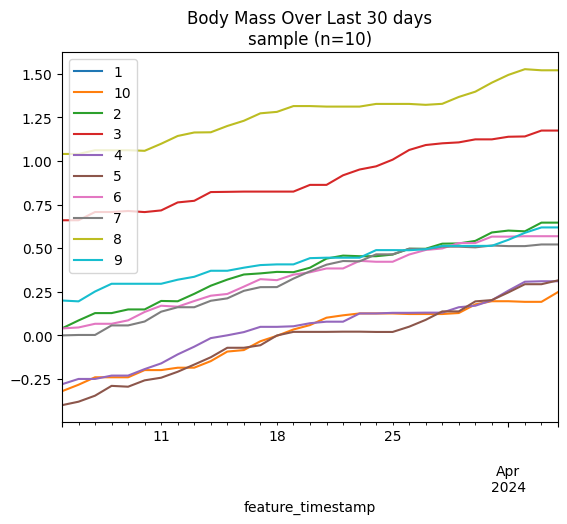

In [53]:
penguins.groupby('entity_id')['body_mass_g'].plot(legend = True, title = 'Body Mass Over Last 30 days\nsample (n=10)')

---
## TEST GENERATE

In [18]:
import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models
vertexai.init(project="statmike-mlops-349915", location="us-central1")
model = GenerativeModel("gemini-1.5-pro-preview-0409")

In [19]:
with open('bqml-model-monitoring-introduction.ipynb - Colab.pdf', 'rb') as file:
    intro = file.read()
with open('bqml-model-monitoring-tutorial.ipynb - Colab.pdf', 'rb') as file:
    tutorial = file.read()

In [20]:
document1 = Part.from_data(
    mime_type="application/pdf",
    data = intro
)
document2 = Part.from_data(
    mime_type="application/pdf",
    data = tutorial
)

In [21]:
text1 = """feature release notes:
You can now perform model monitoring in BigQuery ML. The following model monitoring functions are now in preview:
- ML.DESCRIBE_DATA: compute descriptive statistics for a set of training or serving data.
- ML.VALIDATE_DATA_SKEW: compute the statistics for a set of serving data, and then compare them to the statistics for the data used to train a BigQuery ML model in order to identify anomalous differences between the two data sets.
- ML.VALIDATE_DATA_DRIFT: compute and compare the statistics for two sets of serving data in order to identify anomalous differences between the two data sets.
- ML.TFDV_DESCRIBE: compute fine-grained descriptive statistics for a set of training or serving data. This function provides the same behavior as the TensorFlow tfdv.generate_statistics_from_csv API.
- ML.TFDV_VALIDATE: compute and compare the statistics for training and serving data, or two sets of serving data, in order to identify anomalous differences between the two data sets. This function provides the same behavior as the TensorFlow validate_statistics API.
"""

In [25]:
prompt = """I need help drafting a blog post that needs to be details and several pages long.  This is for a group of new functions for BigQuery ML.  These functions perform model monitorinng in BigQuery ML.  The can be used for BigQuery ML models and for any models whos inference data is collected in BigQuery.  There are two Jupyter notebooks that accompany the blog post to help users get started with the new features.  One is the introduction notebook.  It is shorter and focuses on the new functions.  The other is longer, the tutorial notebook, and it covers a full ML workflow and has explanations as well us insights like how the monitoring metrics are calculated.  Please help draft a blog post that introduces these new features while showing our enthusiasm for how this will simplify the ML workflow for users and given easier access to model monitoring directly in BigQuery."""

In [26]:
responses = model.generate_content(
  ["""introduction notebook:""", document1, """tutorial notebook:""", document2, text1, prompt],
)

In [27]:
print(responses.text)

## Empowering Your ML Models with BigQuery: Introducing Model Monitoring

**The Machine Learning landscape is evolving at an incredible pace.** As organizations increasingly rely on ML models to drive critical business decisions, ensuring their ongoing performance and accuracy becomes paramount. However, the journey from model training to deployment and maintenance can be fraught with challenges. Data drifts, feature skews, and unforeseen changes in real-world data can significantly impact model effectiveness, leading to inaccurate predictions and suboptimal outcomes.

**Today, we are excited to announce the launch of BigQuery ML model monitoring (preview), a powerful suite of features designed to simplify the ML workflow and empower you to maintain the accuracy and effectiveness of your models over time.** By integrating seamlessly with BigQuery, these functionalities provide accessible, efficient, and scalable model monitoring capabilities directly within your data warehouse. 

**Big